# **Planejamento de Trajetória para Soldagem por Pontos com Braços Robóticos em Portas de Veículos**

## Contexto Industrial

### Problema real:
Uma fábrica que produz carrocerias para uma montadora possui um setor dedicado à soldagem das portas. Neste setor, existem duas plataformas de soldagem, cada uma equipada com quatro braços robóticos localizados nas extremidades da plataforma. Esses robôs realizam a soldagem de portas em 110 pontos diferentes, distribuídos em quatro tipos distintos de soldagem.

O principal desafio desse setor é atingir a meta de tempo de ciclo (TC). Os braços robóticos precisam soldar todos os pontos no menor tempo possível, respeitando as restrições operacionais da produção.

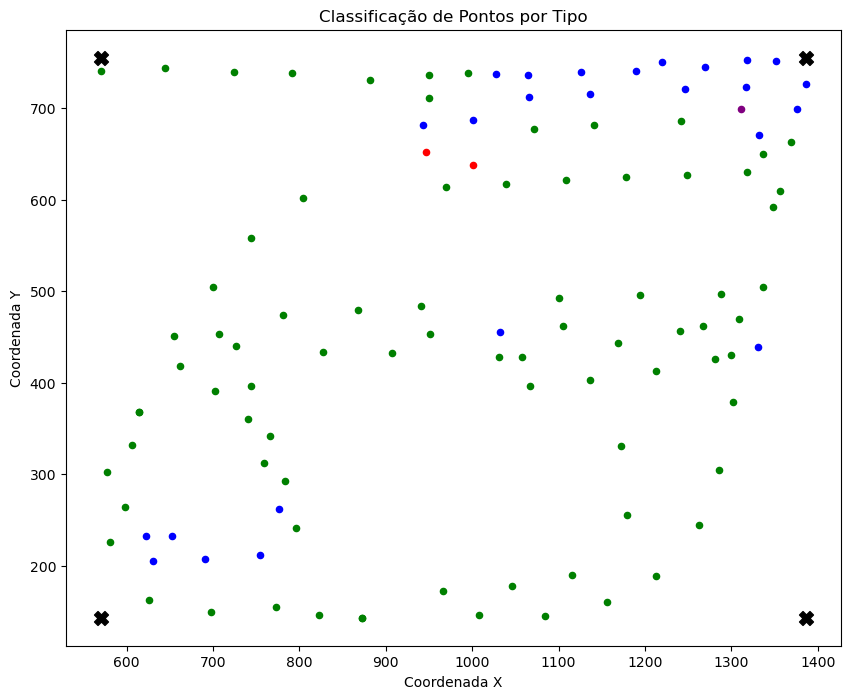

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("Posição e Tipo - Pontos de Solda.xlsx", sheet_name= "Dados")

x_coords = df['x']
y_coords = df['y']
tipos = df['Tipo de ponto']

nomes_tipo = tipos.unique()

plt.figure(figsize=(10, 8))

cores = {'D3,5': 'red', 'RIB': 'blue', 'D6': 'green', 'SURFACE': 'purple'}

for tipo in nomes_tipo:
    df_tipo = df[df['Tipo de ponto'] == tipo]
    plt.scatter(df_tipo['x'], 
                df_tipo['y'],
                color=cores[tipo], s=20)

menor_x, maior_x= np.min(x_coords), np.max(x_coords)
menor_y, maior_y = np.min(y_coords), np.max(y_coords)

maquinas = {
    'M1': (menor_x, menor_y),
    'M2': (menor_x, maior_y),
    'M3': (maior_x, menor_y),
    'M4': (maior_x, maior_y)
}

for nome, (mx, my) in maquinas.items():
    plt.scatter(mx, my, color='black', marker='X', s=100)
    
plt.title("Classificação de Pontos por Tipo")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")

plt.savefig('dados_reais.png')

plt.show()

### Problema modelado:
Devido à complexidade da modelagem e da geração de soluções aplicáveis ao problema real, optou-se por modelar uma versão simplificada. Essa modelagem considera uma célula de soldagem com um número reduzido de pontos, facilitando a análise e o desenvolvimento de soluções.

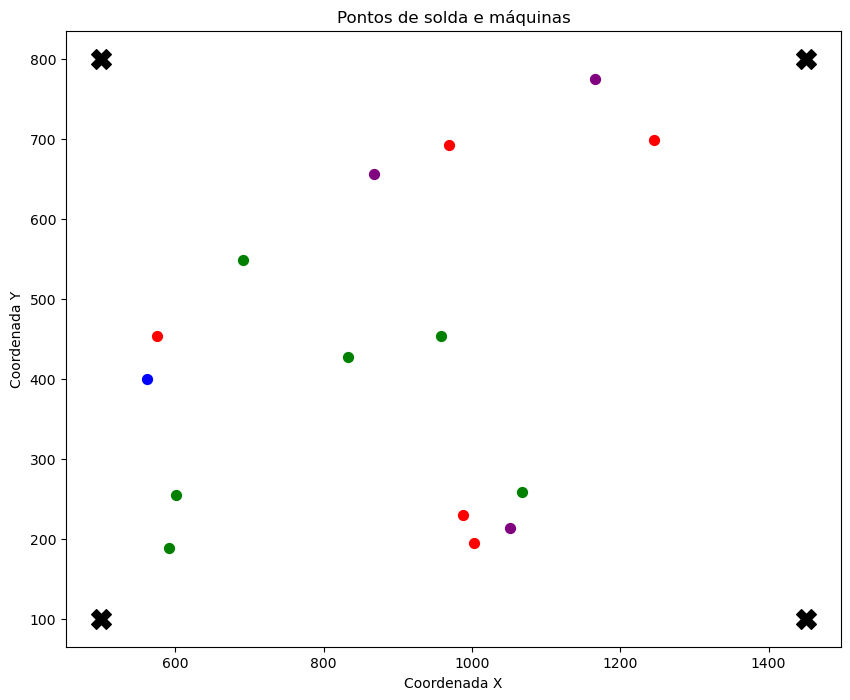

In [2]:
total_pontos = 15
tipos = ['Tipo A', 'Tipo B', 'Tipo C', 'Tipo D']
cores = ['red', 'blue', 'green', 'purple']
menor_x, maior_x = 500, 1450
menor_y, maior_y = 100, 800

maquinas = {
    'M1': (menor_x, menor_y),
    'M2': (menor_x, maior_y),
    'M3': (maior_x, menor_y),
    'M4': (maior_x, maior_y)
}

np.random.seed(2)
cortes = sorted(np.random.choice(range(1, total_pontos), 3, replace=False))
quantidades = [
    cortes[0],
    cortes[1] - cortes[0],
    cortes[2] - cortes[1],
    total_pontos - cortes[2]
]

pontos = []
for i in range(4):
    tipo = tipos[i]
    cor = cores[i]
    for _ in range(quantidades[i]):
        x = np.random.uniform(menor_x, maior_x)
        y = np.random.uniform(menor_y, maior_y)
        pontos.append((x, y, tipo, cor))

plt.figure(figsize=(10, 8))
    
for i, ponto in enumerate(pontos):
    x_val, y_val, tipo, cor = ponto
    plt.scatter(x_val, y_val, color=cor, s=50)

for k, (nome, (x_m, y_m)) in enumerate(maquinas.items()):
    plt.scatter(x_m, y_m, c='black', marker='X', s=200)

plt.title('Pontos de solda e máquinas')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')

plt.savefig('dados_gerados_20.png')

plt.show()

# Modelo Matemático de Roteamento de Soldagens

## Conjuntos

- $M$: Conjunto de máquinas  
- $P$: Conjunto de pontos de solda  
- $V = M \cup P$: Conjunto de todos os vértices  

## Parâmetros

- $\mathrm{dist}_{ij}$: Distância euclidiana entre os vértices $i$ e $j$, para $i, j \in P$.  
- $v$: Velocidade do robô.  
- $t_r$: Tempo de espera necessário para o resfriamento da solda.  
- $t_s$: Tempo de setup necessário em caso de troca de tipo.  
- $t_{ij}$: Tempo total para o robô percorrer de $i$ a $j$, calculado por:

$$
t_{ij} = \frac{\mathrm{dist}_{ij}}{v} + t_r + 
\begin{cases}
t_s, & \text{se } i,j \in P \text{ e são de tipos diferentes}, \\
0, & \text{caso contrário}.
\end{cases}
$$

## Variáveis de Decisão

- $x_{kij} \in \{0,1\}$:  
  $$
  x_{kij} = \begin{cases}
  1, & \text{se a máquina } k \text{ vai de } i \text{ a } j, \quad \forall i,j \in P, \forall k \in M \\
  0, & \text{caso contrário}
  \end{cases}
  $$

- $u_{ki} \geq 0$: Variável auxiliar para eliminação de sub-rotas (MTZ), para todo $i \in P, k \in M$.  
- $Z \geq 0$: Tempo de ciclo de rota (makespan).  

## Modelo Matemático

$$
\min Z
$$

Sujeito a:

$$
\sum_{k \in M} \sum_{i \in V} x_{kij} = 1, \quad \forall j \in P \tag{1}
$$

$$
\sum_{j \in P} x_{kkj} = 1, \quad \forall k \in M \tag{2}
$$

$$
\sum_{i \in P} x_{kik} = 1, \quad \forall k \in M \tag{3}
$$

$$
x_{kij} = 0, \quad \forall k \in M, \ \forall i \in M, \ \forall j \in V \tag{4}
$$

$$
\sum_{i \in V} x_{kij} = \sum_{i \in V} x_{kji}, \quad \forall k \in M, \ \forall j \in V \tag{5}
$$

$$
u_{ki} - u_{kj} + |V| \cdot x_{kij} \leq |V| - 1, \quad \forall k \in M, \ \forall i,j \in P, \ i \neq j \tag{6}
$$

$$
Z \geq \sum_{i \in V} \sum_{j \in V} t_{ij} \cdot x_{kij}, \quad \forall k \in M \tag{7}
$$

### Comentários das restrições:

- (1) Cada ponto $j \in P$ deve ser visitado exatamente uma vez por alguma máquina $k \in M$.  
- (2) Cada máquina $k$ inicia no seu próprio vértice $k$.  
- (3) Cada máquina $k$ termina no seu próprio vértice $k$.  
- (4) Impede que máquinas visitem outras máquinas (não permite transição entre máquinas).  
- (5) Garante que o fluxo que chega em um ponto $j$ seja igual ao fluxo que sai, para manter a continuidade da rota.  
- (6) Eliminação de subtours, usando a formulação MTZ.  
- (7) O tempo máximo $Z$ deve ser maior ou igual ao tempo total de cada rota da máquina $k$.  


In [7]:
import gurobipy as gp
from gurobipy import GRB

# Criação do modelo
modelo = gp.Model("Roteamento de soldagens com depósitos")

# Dimensões do problema
num_pontos = len(pontos)          # Número de pontos de solda
num_maquinas = len(maquinas)      # Número de máquinas/depósitos
num_vertices = num_maquinas + num_pontos  # Total de vértices (máquinas + pontos)

# Preparação das coordenadas (máquinas primeiro, depois pontos)
coordenadas = list(maquinas.values()) + [(p[0], p[1]) for p in pontos]

# Matriz de distâncias
distancias = np.zeros((num_vertices, num_vertices))
for i in range(num_vertices):
    for j in range(num_vertices):
        dx = coordenadas[i][0] - coordenadas[j][0]
        dy = coordenadas[i][1] - coordenadas[j][1]
        distancias[i][j] = np.hypot(dx, dy)

# Cálculo da matriz de tempos
tempo_resfriamento = 2
velocidade = 40
tempo_setup = 5

# Cria matriz de tempos
tempos = np.zeros((num_vertices, num_vertices))
for i in range(num_vertices):
    for j in range(num_vertices):
        if i == j:
            tempos[i][j] = 0
        else:
            # Tempo base é distância/velocidade + tempo de resfriamento
            tempos[i][j] = (distancias[i][j]/velocidade) + tempo_resfriamento
            
            # Adiciona tempo de setup se mudar entre tipos diferentes de pontos
            if i >= num_maquinas and j >= num_maquinas:  # Ambos são pontos de solda
                if pontos[i-num_maquinas][2] != pontos[j-num_maquinas][2]:  # Tipos diferentes
                    tempos[i][j] += tempo_setup

# Variáveis de decisão
x = {}
for k in range(num_maquinas):
    for i in range(num_vertices):
        for j in range(num_vertices):
            x[k,i,j] = modelo.addVar(vtype=GRB.BINARY, name=f"x_{k}_{i}_{j}")

tempo_maximo = modelo.addVar(vtype=GRB.CONTINUOUS, name="tempo_maximo")
u = {}
for k in range(num_maquinas):
    for i in range(num_vertices):
        u[k,i] = modelo.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=num_vertices, name=f"u_{k}_{i}")

# Objetivo: minimizar o tempo máximo de rota
modelo.setObjective(tempo_maximo, GRB.MINIMIZE)

# Restrições
# 1. Cada ponto de solda visitado exatamente uma vez
for j in range(num_maquinas, num_vertices):
    modelo.addConstr(
        gp.quicksum(x[k,i,j] for k in range(num_maquinas) for i in range(num_vertices) if i != j) == 1,
        name=f"visita_unica_{j}"
    )
# Bloquear arcos entre depósitos diferentes
for k in range(num_maquinas):
    for i in range(num_maquinas):
        if i != k:  # Outros depósitos
            for j in range(num_vertices):
                if j != k:
                    modelo.addConstr(x[k,i,j] == 0)

            
# 2. Cada máquina sai do seu depósito exatamente uma vez
for k in range(num_maquinas):
    modelo.addConstr(
        gp.quicksum(x[k,k,j] for j in range(num_maquinas, num_vertices)) == 1,
        name=f"saida_deposito_{k}"
    )

# 3. Cada máquina retorna ao seu depósito
for k in range(num_maquinas):
    modelo.addConstr(
        gp.quicksum(x[k,i,k] for i in range(num_maquinas, num_vertices)) == 1,
        name=f"retorno_deposito_{k}"
    )

# 4. Conservação de fluxo (PARA TODOS OS NÓS, EXCETO O PRÓPRIO DEPÓSITO)
for k in range(num_maquinas):
    for j in range(num_vertices):
        if j != k:  # Exclui o depósito da máquina k
            modelo.addConstr(
                gp.quicksum(x[k,i,j] for i in range(num_vertices) if i != j) == 
                gp.quicksum(x[k,j,m] for m in range(num_vertices) if m != j),
                name=f"fluxo_{k}_{j}"
            )
            
# 5. Eliminação de sub-rotas (MTZ)
for k in range(num_maquinas):
    for i in range(num_maquinas, num_vertices):
        for j in range(num_maquinas, num_vertices):
            if i != j:
                modelo.addConstr(
                    u[k,i] - u[k,j] + num_vertices * x[k,i,j] <= num_vertices - 1,
                    name=f"subtour_{k}_{i}_{j}"
                )

                        
# 6. Definição do tempo máximo
for k in range(num_maquinas):
    modelo.addConstr(
        tempo_maximo >= gp.quicksum(tempos[i][j] * x[k,i,j] for i in range(num_vertices) for j in range(num_vertices) if i != j),
        name=f"tempo_max_por_maquina_{k}"
    )

# Resolve o modelo
modelo.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1155 rows, 1521 columns and 7900 nonzeros
Model fingerprint: 0xa2616c2f
Variable types: 77 continuous, 1444 integer (1444 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 216 rows and 308 columns
Presolve time: 0.02s
Presolved: 939 rows, 1213 columns, 6804 nonzeros
Variable types: 61 continuous, 1152 integer (1152 binary)
Found heuristic solution: objective 227.3101463

Root relaxation: objective 3.670879e+01, 547 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap

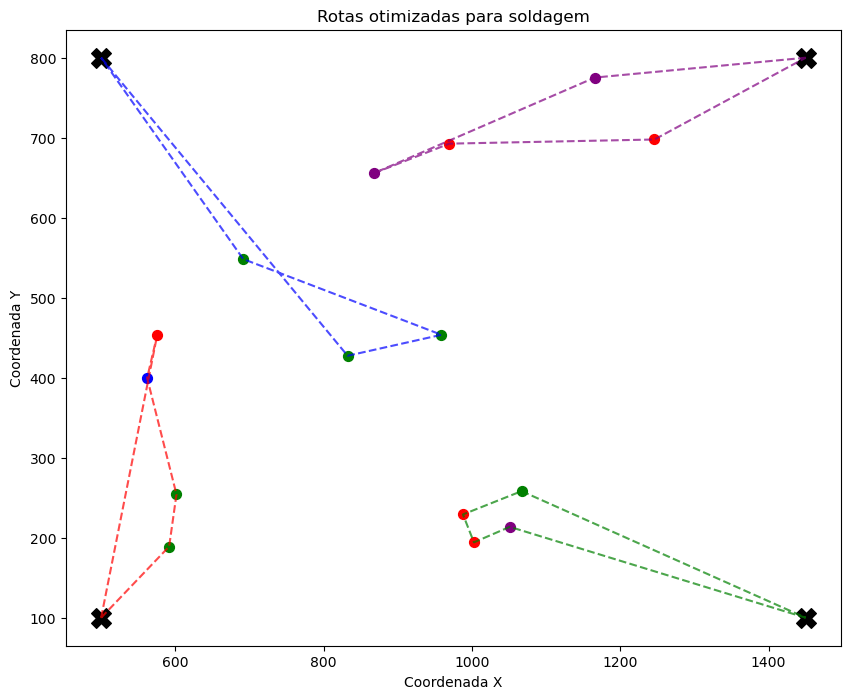

Solução ótima encontrada!
Tempo máximo (makespan): 45.50 unidades de tempo

Rota da máquina 1 (Tempo: 39.05):
 0. Depósito M1
 1. Ponto 7 (Tipo Tipo C)
 2. Ponto 9 (Tipo Tipo C)
 3. Ponto 6 (Tipo Tipo B)
 4. Ponto 5 (Tipo Tipo A)
 5. Depósito M1

Rota da máquina 2 (Tempo: 38.71):
 0. Depósito M2
 1. Ponto 10 (Tipo Tipo C)
 2. Ponto 12 (Tipo Tipo C)
 3. Ponto 11 (Tipo Tipo C)
 4. Depósito M2

Rota da máquina 3 (Tempo: 45.09):
 0. Depósito M3
 1. Ponto 14 (Tipo Tipo D)
 2. Ponto 1 (Tipo Tipo A)
 3. Ponto 2 (Tipo Tipo A)
 4. Ponto 8 (Tipo Tipo C)
 5. Depósito M3

Rota da máquina 4 (Tempo: 45.50):
 0. Depósito M4
 1. Ponto 15 (Tipo Tipo D)
 2. Ponto 13 (Tipo Tipo D)
 3. Ponto 4 (Tipo Tipo A)
 4. Ponto 3 (Tipo Tipo A)
 5. Depósito M4


In [8]:
# Função para extrair rotas
def extrair_rota(k):
    rota = [k]
    atual = k
    while True:
        proximo = None
        for j in range(num_vertices):
            if j != atual and x[k,atual,j].X > 0.99:
                proximo = j
                break
        if proximo is None:
            break
        rota.append(proximo)
        if proximo == k:
            break
        atual = proximo
    return rota

if modelo.status == GRB.OPTIMAL or modelo.status == GRB.TIME_LIMIT:
    plt.figure(figsize=(10, 8))
    
    # Plota pontos de solda
    for i, ponto in enumerate(pontos):
        x_val, y_val, tipo, cor = ponto
        plt.scatter(x_val, y_val, color=cor, s=50)
    
    # Plota máquinas
    for k, (nome, (x_m, y_m)) in enumerate(maquinas.items()):
        plt.scatter(x_m, y_m, c='black', marker='X', s=200)
    
    # Plota rotas
    cores_rotas = ['red', 'blue', 'green', 'purple']
    for k in range(num_maquinas):
        rota = extrair_rota(k)
        coordenadas_rota = [coordenadas[i] for i in rota]
        x_vals = [p[0] for p in coordenadas_rota]
        y_vals = [p[1] for p in coordenadas_rota]
        plt.plot(x_vals, y_vals, linestyle='--', color=cores_rotas[k], alpha=0.7, label=f'Rota {k+1}')
    
    plt.title('Rotas otimizadas para soldagem')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')

    plt.savefig('solucao_20.png')
    
    plt.show()
    
    # Imprime detalhes da solução
    print("Solução ótima encontrada!")
    print(f"Tempo máximo (makespan): {tempo_maximo.X:.2f} unidades de tempo")
    for k in range(num_maquinas):
        rota = extrair_rota(k)
        tempo_rota = sum(tempos[rota[i]][rota[i+1]] for i in range(len(rota)-1))
        print(f"\nRota da máquina {k+1} (Tempo: {tempo_rota:.2f}):")
        for i, no in enumerate(rota):
            if no < num_maquinas:
                print(f" {i}. Depósito {list(maquinas.keys())[no]}")
            else:
                print(f" {i}. Ponto {no-num_maquinas+1} (Tipo {pontos[no-num_maquinas][2]})")
else:
    print("Não foi encontrada solução viável.")
    print(f"Status: {modelo.status}")